## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

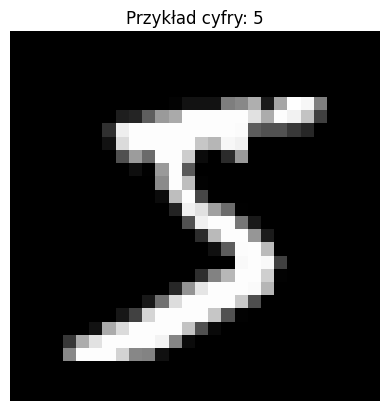

In [15]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

# **Rozwiazanie:**

## **Punkt 1 - wnioski z poprzednich zadań:**


1. **Przygotowanie danych** – Titanic pokazał, że dane muszą być przygotowane
2. **Baseline** - Titanic nauczył, że należy zaczynać od prostego modelu żeby mieć punkt odniesienia i porównanie do naszego.
3. **Overfitting** - tu też trzeba uważać, żeby sieć się nie „nauczyła na pamięć”

## **Punkt 2 - Setup:**

In [16]:
# Przekopiowane z notatnika z lekkimi zmianami

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cpu


Teraz wykonamy normalizacje danych testowych i treningowych + przekonwertujemy je do tensora PyTorch

In [17]:
# Konwersja danych treningowych do tensora PyTorch + normalizacja (0-1 zamiast 0-255)
x_train_t = torch.tensor(x_train, dtype=torch.float32) / 255.0
y_train_t = torch.tensor(y_train, dtype=torch.long)

x_test_t = torch.tensor(x_test, dtype=torch.float32) / 255.0
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Rozmiar zbioru treningowego: {x_train_t.shape}")
print(f"Rozmiar zbioru testowego: {x_test_t.shape}")

Rozmiar zbioru treningowego: torch.Size([60000, 28, 28])
Rozmiar zbioru testowego: torch.Size([10000, 28, 28])


Chciałem trooche sie pobawić samemu w obróbkę danych i troche nie kumam dlaczego tutaj nie ma tego color channelu, który powinien być równy jeden. W każdym razie dodaję go poniżej, ponieważ CNN oczekuje [batch, channel, H, W]

In [18]:
x_train_t = x_train_t.unsqueeze(1)  # (60000, 1, 28, 28)
x_test_t = x_test_t.unsqueeze(1)    # (10000, 1, 28, 28)

print(f"Poprawiony rozmiar zbioru treningowego: {x_train_t.shape}")
print(f"Poprawiony rozmiar zbioru testowego: {x_test_t.shape}")
print("\n")

# Stworzenie Datasetów i DataLoaderów
train_dataset = TensorDataset(x_train_t, y_train_t)
test_dataset = TensorDataset(x_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # przy trenowaniu miesza kolejność próbek (ważne dla lepszego uczenia).
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False) # przy testowaniu nie ma sensu mieszać, testujemy całość „po kolei”.

print("Rozmiar batcha treningowego:", next(iter(train_loader))[0].shape)
print("Rozmiar batcha testowego:", next(iter(test_loader))[0].shape)

Poprawiony rozmiar zbioru treningowego: torch.Size([60000, 1, 28, 28])
Poprawiony rozmiar zbioru testowego: torch.Size([10000, 1, 28, 28])


Rozmiar batcha treningowego: torch.Size([64, 1, 28, 28])
Rozmiar batcha testowego: torch.Size([1000, 1, 28, 28])


Funkcja treningowa:

In [19]:
def model_train(model, loader):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def model_test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            correct += (pred.argmax(1) == yb).sum().item()
            total += yb.size(0)
    return correct / total

## **Punkty 3 - Baseline MLP:**

Baseline

In [20]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inicjalizacja
model_mlp = MLP().to(device)
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Trening MLP:

In [21]:
for epoch in range(10):
    loss = model_train(model_mlp, train_loader)
    acc = model_test(model_mlp, test_loader)
    print(f"Epoch {epoch+1}: loss={loss:.4f}, acc={acc:.4f}")

Epoch 1: loss=0.2872, acc=0.9595
Epoch 2: loss=0.1096, acc=0.9708
Epoch 3: loss=0.0727, acc=0.9760
Epoch 4: loss=0.0538, acc=0.9798
Epoch 5: loss=0.0382, acc=0.9780
Epoch 6: loss=0.0307, acc=0.9798
Epoch 7: loss=0.0267, acc=0.9787
Epoch 8: loss=0.0216, acc=0.9783
Epoch 9: loss=0.0176, acc=0.9743
Epoch 10: loss=0.0165, acc=0.9810


## **Punkt 4 - CNN:**


In [22]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc2(x)

        return x

# Inicjalizacja
model_cnn = CNN().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Trening CNN:

In [23]:
for epoch in range(10):
    loss = model_train(model_cnn, train_loader)
    acc = model_test(model_cnn, test_loader)
    print(f"Epoch {epoch+1}: loss={loss:.4f}, acc={acc:.4f}")

Epoch 1: loss=0.2501, acc=0.9805
Epoch 2: loss=0.0670, acc=0.9869
Epoch 3: loss=0.0500, acc=0.9837
Epoch 4: loss=0.0408, acc=0.9875
Epoch 5: loss=0.0346, acc=0.9852
Epoch 6: loss=0.0290, acc=0.9878
Epoch 7: loss=0.0255, acc=0.9878
Epoch 8: loss=0.0222, acc=0.9878
Epoch 9: loss=0.0193, acc=0.9889
Epoch 10: loss=0.0171, acc=0.9890


## **Punkt 5 - eksperyment CNN z BatchNorm i dropout:**

In [24]:
class CNN_exp(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_exp, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Normalizuje aktywacje - stabilizuje trening
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)  # Wyłącza 25% neuronów - zapobiega overfittingowi

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc2(x)

        return x

# Inicjalizacja
model_cnn_exp = CNN_exp().to(device)
optimizer = optim.Adam(model_cnn_exp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [25]:
for epoch in range(5):
    loss = model_train(model_cnn_exp, train_loader)
    acc = model_test(model_cnn_exp, test_loader)
    print(f"Epoch {epoch+1}: loss={loss:.4f}, acc={acc:.4f}")

Epoch 1: loss=0.2135, acc=0.9775
Epoch 2: loss=0.0893, acc=0.9854
Epoch 3: loss=0.0735, acc=0.9873
Epoch 4: loss=0.0645, acc=0.9876
Epoch 5: loss=0.0604, acc=0.9873


## **Wnioski:**

1. Baseline (MLP) gorzej niż CNN.  
2. CNN – ~99% dokładności naturalny wybór dla obrazów.  
3. CNN z BatchNorm i dropout jeszcze lepszy wynik

W praktyce – prosty CNN wystarcza na MNIST, ale na bardziej rozbudowanych datasetach może architektura i regularizacja mają dużo większe znaczenie.
